# Лабораторная работа
## Постановка задачи
С использованием *MPI* и *PyTorch* необходимо распараллелить процесс обучения нейросети.



## MPI
**Message Passing Interface** (MPI, интерфейс передачи сообщений) — программный интерфейс (API) для передачи информации, который позволяет обмениваться сообщениями между процессами, выполняющими одну задачу.

MPI является наиболее распространённым стандартом интерфейса обмена данными в параллельном программировании, существуют его реализации для большого числа компьютерных платформ. Используется при разработке программ для кластеров и суперкомпьютеров.

Базовым механизмом связи между MPI процессами является передача и прием сообщений. Сообщение несёт в себе передаваемые данные и информацию, позволяющую принимающей стороне осуществлять их выборочный приём.



## PyTorch
**PyTorch** — фреймворк машинного обучения для языка Python с открытым исходным кодом, созданный на базе Torch. Используется для решения различных задач: компьютерное зрение, обработка естественного языка.

PyTorch использует Tensor в качестве основной структуры данных, которая похожа на массив NumPy, что позволяет ускорить различные математические операции.

На рисунке ниже описан типичный рабочий процесс вместе с важными модулями, связанными с каждым шагом:

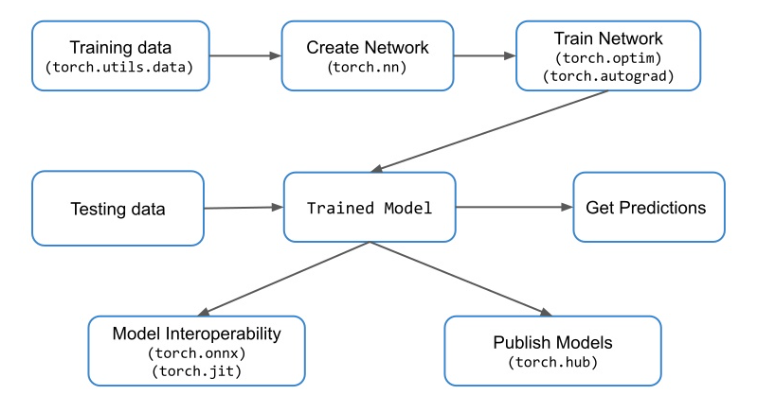

**1. Загрузка и обработка данных**

В PyTorch для загрузки и обработки данных есть отдельный метод torch.utils.data

Два важных класса в этом модуле — *Dataset* и *DataLoader*.

- *Dataset* построен поверх тензорного типа данных и используется в основном для пользовательских наборов данных.

- *DataLoader* используется, когда есть большой набор данных, и необходимо загрузить данные из Dataset в фоновом режиме, чтобы он был готов и ждал цикла обучения.

**2. Построение Нейронной Сети**

Модуль torch.nn используется для создания нейронных сетей. Она обеспечивает все общие слои нейронной сети как полностью Соединенные слои, сверточные слои, активация и функции потерь.

Как только архитектура сети создана и данные готовы к подаче в сеть, нужны методы обновления весов и смещений, чтобы сеть начала учиться. Эти утилиты предоставляются в torch.optim. Точно так же для автоматического дифференцирования, которое требуется во время обратного прохода, используется torch.autograd.

**3. Вывод Модели**

После обучения модель можно использовать для прогнозирования выходных данных тестовых наборов или даже новых наборов данных. Этот процесс называется выводом модели.

PyTorch также предоставляет TorchScript, который может использоваться для запуска моделей независимо от среды выполнения Python. Это можно рассматривать как виртуальную машину с инструкциями, в основном специфичными для тензоров.

## План решения
Задание состоит из 2-х этапов:
####Этап A:
1. Даны 4 ядра: одно из них управляющее — Master Node, остальные представляют собой Compute Nodes.
2. Датасет разрезается на 3 части, и разные части датасета пересылаются для обучения на Compute Nodes. Далее Master Node рассылает на Compute Nodes CNN, которые там обучаются. 
3. После обучения результаты обучения из Compute Nodes пересылаются обратно в Master Node.

#### Этап B:
1. Master Node подается на вход объект (объекты) данных, которые необходимо классифицировать/предсказать. Master Node отсылает эти объекты на Compute Nodes, каждое из которых делает предсказание на основе своей обученной модели.
2. Далее это предсказание возвращается в Master Node, где Master Node среди этих 3-х предсказаний устраивает ансамблевое голосование.

## Выбор датасета
Для решения этой задачи был выбран датасет MNIST с использованием CNN (Сверточная нейронная сеть).

MNIST dataset — это объемная база данных образцов рукописного написания цифр, которая содержит в себе 60000 изображений для обучения и 10000 изображений для тестирования.

## Аппаратное обеспечение и ПО
Лабораторная работа была выполнена в среде разработки Jupyter Notebook в Google Colaboratory.

## Основные моменты программы
В работе был использован пакет mpi4py, который предоставляет привязки Python для стандарта MPI. 

### Голосование
Алгоритм голосования представляет собой вычисление наиболее часто встечающегося ответа и выглядит следующим образом:

```
  '''
  Voting for the most frequently occuring prediction
  Голосование за наиболее часто встречающееся предсказание 
  '''
  preds_all_res = [] # The resulting prediction after voting 
                     # Результирующее предсказание после голосованния 

  for num in range(len(preds_res[0])):
    chek_dict = {}
    for procid in range(1, p):
      cur_num = preds_res[procid - 1][num] # The current number, 
                                           # which was predicted
                                           # Текущее число, которое было 
                                           # предсказано

      num_count = chek_dict.get(cur_num, 0)
      num_count = num_count + 1
      chek_dict[cur_num] = num_count


    '''
    Max voting number
    Максимальное число голосов за цифру
    '''
    max_vote_num = max(chek_dict.items(), key = operator.itemgetter(1))[0]
    preds_all_res.append(max_vote_num)
```





## Реализация

In [ ]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%%writefile MPI.py
from mpi4py import MPI
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data.dataset import random_split
import operator
import torch.utils.data as data_utils

# Count of the numbers, which will be printed
# Количество чисел, которые будут напечатаны
print_num_cout = 30

# Defining the CNN model
# Определение СНС модели
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 1, 
                                         out_channels = 16, 
                                         kernel_size = 5, 
                                         stride = 1, 
                                         padding = 2),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size = 2))
    
    self.conv2 = nn.Sequential(nn.Conv2d(in_channels = 16, 
                                         out_channels = 32, 
                                         kernel_size = 5, 
                                         stride = 1, 
                                         padding = 2),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size = 2))
    
    self.out = nn.Linear(in_features = 32 * 7 * 7, out_features = 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)

    x = x.view(x.size(0), -1)
    output = self.out(x)
    return output, x

# Training the model
# Тренировка модели
def train(train_num, num_epochs, cnn, loaders_trains):

  # Defining loss function 
  # Определение функции потерь
  loss_func = nn.CrossEntropyLoss()

  # Defining a Optimization Function
  # Определение оптимизационной функции
  optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

  cnn.train()

  total_step = len(loaders_trains)

  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loaders_trains):
      batch_x = Variable(images)
      batch_y = Variable(labels)

      output = cnn(batch_x)[0]

      loss = loss_func(output, batch_y)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if (i + 1) % 100 == 0:
        print('Train num {}, Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(train_num, 
                                                                              epoch + 1, 
                                                                              num_epochs, 
                                                                              i + 1,
                                                                              total_step,
                                                                              loss.item()))
        pass
      pass
    pass

# Evaluating the model on test data
# Оценивание модели на тестовых данных
def test(cnn_for_test):
  cnn_for_test.eval()

  with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in loaders['test']:
      test_output, last_layer = cnn_for_test(images)

      pred_y = torch.max(test_output, 1)[1].data.squeeze()

      accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

      pass

    print('Test accuracy of the model on the 10000 test images: %.2f' % accuracy)

    pass


comm = MPI.COMM_WORLD
my_rank = comm.Get_rank()
p = comm.Get_size()

# Downloading MNIST dataset in local system
# Скачивание датасета MNIST в локальную систему
train_data = datasets.MNIST(root = 'data', train = True, 
                            transform = ToTensor(), download = True)

test_data = datasets.MNIST(root = 'data', train = False, 
                          transform = ToTensor())

train_part = int(len(train_data) / 3)
#trains = random_split(train_data, [train_part, train_part, train_part])


indices = torch.arange(6000)
cut_train = data_utils.Subset(train_data, indices)
trains = random_split(cut_train, [2000, 2000, 2000])


# Preparing data for training with DataLoaders
# Подготовка данных для тренировки с использованием DataLoaders
loaders = {'train1' : DataLoader(trains[0],
                              batch_size = 100,
                              shuffle = True,
                              num_workers = 1),
          'train2' : DataLoader(trains[1],
                              batch_size = 100,
                              shuffle = True,
                              num_workers = 1),
          'train3' : DataLoader(trains[2],
                              batch_size = 100,
                              shuffle = True,
                              num_workers = 1),
          'test' : DataLoader(test_data,
                              batch_size = 100,
                              shuffle = True,
                              num_workers = 1)}


if my_rank != 0:

  '''
  Receiving CNN from Master Node
  Получение СНС от Главной Ноды
  '''
  cnn_proc = comm.recv(source = 0)


  '''
  Receiving split train dataset and its num 
  Получение разрезанного датасета и номер части
  '''
  subset = comm.recv(source = 0)#Get subset
  train_num = comm.recv(source = 0)#Get train num subset

  #print('Training rank started = ', my_rank)


  '''
  Training
  Тренировка
  '''
  num_epochs = 10
  train(train_num, num_epochs, cnn_proc, subset)
  #print('Training rank ended = ', my_rank)

  test(cnn_proc)


  '''
  Receiving images, which need to predict, from Master Node
  Получение картинок, которые надо предсказать, от Главной Ноды
  '''
  #test_proc = comm.recv(source = 0)#Get data for testing
  imgs = comm.recv(source = 0) #Get images


  '''
  Prediction
  Предсказание
  '''
  #print('Test rank started = ', my_rank)
  test_output, last_layer = cnn_proc(imgs[:print_num_cout])
  pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
  #print('Test rank ended = ', my_rank)


  '''
  Sending predicted numbers to Master Node
  Отправка предсказанных чисел на Главную Ноду
  '''
  preds_proc = comm.send(pred_y, dest = 0)
  #print('Result was sent from ', my_rank)

else:
  #print('Here my rank started = ', my_rank)

  '''
  Sending CNN, dataset train batch, number of train batch for every Compute Node
  Отправка СНС, часть и номер тренировочных данных датасета 
  на каждый Вычислительный Узел (ВУ)
  '''
  for procid in range(1, p):
    cnn = CNN()
    train_num = 'train' + str(procid)
    comm.send(cnn, dest = procid) # Send cnn
    comm.send(loaders[train_num], dest = procid) # Send a batch of datas
    comm.send(train_num, dest = procid) # Send train num of subset

  sample = next(iter(loaders['test']))
  imgs, lbls = sample
  actual_number = lbls[:print_num_cout].numpy()


  '''
  Sending data objects (images) for every Compute Node, 
  which Master Node is trying to predict
  Отправка объектов данных (картинок) на каждый ВУ, 
  которые Главная Нода пытается предсказать
  '''
  for procid in range(1, p):
    #comm.send(sample, dest = procid)
    comm.send(imgs, dest = procid)

  print(f'Actual number: {actual_number}')


  '''
  Receiving prediction numbers from every Compute Node
  Получение предсказаний с каждого ВУ
  '''
  preds_res = []

  for procid in range(1, p):
    pred_y = comm.recv(source = procid)
    preds_res.append(pred_y)

  for procid in range(1, p):
    print(f'[{procid}] Prediction number: {preds_res[procid - 1]}')


  '''
  Voting for the most frequently occuring prediction
  Голосование за наиболее часто встречающееся предсказание 
  '''
  preds_all_res = [] # The resulting prediction after voting 
                     # Результирующее предсказание после голосованния 

  for num in range(len(preds_res[0])):
    chek_dict = {}
    for procid in range(1, p):
      cur_num = preds_res[procid - 1][num] # The current number, 
                                           # which was predicted
                                           # Текущее число, которое было 
                                           # предсказано

      num_count = chek_dict.get(cur_num, 0)
      num_count = num_count + 1
      chek_dict[cur_num] = num_count


    '''
    Max voting number
    Максимальное число голосов за цифру
    '''
    max_vote_num = max(chek_dict.items(), key = operator.itemgetter(1))[0]
    preds_all_res.append(max_vote_num)

  print(f'Results of the voting: {preds_all_res}'.replace(',', ''))
  

  #print('Here my rank ended = ', my_rank)

MPI.Finalize()

Overwriting MPI.py


## Результат работы программы:
В результате было получено следующее:
- Точность каждой из моделей.
- Выведены метки каждого изображения, которое Master Node пытается предсказать.
- Ниже показаны предсказания каждого процесса.
- В результате выведено предсказание, основанное на голосовании.

In [ ]:
! mpiexec -np 4 --allow-run-as-root python MPI.py

Test accuracy of the model on the 10000 test images: 0.92
Test accuracy of the model on the 10000 test images: 0.93
Test accuracy of the model on the 10000 test images: 0.94
Actual number: [5 9 4 9 9 6 5 6 0 7 3 2 9 5 1 3 4 1 5 2 2 6 1 9 3 6 8 8 5 1]
[1] Prediction number: [5 9 4 9 9 6 5 6 0 7 3 2 9 5 1 3 4 1 5 2 2 6 1 9 3 6 8 8 5 1]
[2] Prediction number: [5 9 4 9 8 6 5 6 0 7 7 2 9 5 1 3 4 1 5 8 2 6 1 9 3 6 8 8 5 1]
[3] Prediction number: [5 9 4 9 8 6 5 6 0 7 3 2 9 5 1 3 4 1 5 2 2 6 1 9 3 6 8 8 5 1]
Results of the voting: [5 9 4 9 8 6 5 6 0 7 3 2 9 5 1 3 4 1 5 2 2 6 1 9 3 6 8 8 5 1]


## Вывод:

В ходе выполнения работы были сформированы следующие выводы:

- Плюсом распараллеливания в сравнении с использованием одного процесса является возможность выполнения нескольких задач в один момент времени.

- Кроме того, распараллеливание уменьшает время выполнения задачи, что в свою очередь может иметь большое значение при выполнении сложных вычислений на больших массивах данных.

- К трудностям можно отнести сложность в понимании и написании алгоритмов, работающих распределенно.